In [2]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(0)

import os
import wget
from pathlib import Path
import shutil
import gzip

from matplotlib import pyplot as plt
%matplotlib inline

# Download ForestCoverType dataset

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
dataset_name = 'forest-cover-type'
tmp_out = Path('./data/'+dataset_name+'.gz')
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [4]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, tmp_out.as_posix())
    with gzip.open(tmp_out, 'rb') as f_in:
        with open(out, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

File already exists.


# Load data and split
Same split as in original paper

In [6]:
target = "Cover_Type"

bool_columns = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
    "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
    "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
    "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
    "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
    "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
    "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
    "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
    "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
    "Soil_Type40"
]

int_columns = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (int_columns + bool_columns + [target])
test_feature_columns = (int_columns + bool_columns)

In [7]:
train = pd.read_csv(out, header=None, names=feature_columns)
train_kaggle = pd.read_csv("../../kaggle_data/forestCoverTypePrediction/test.csv", header=None, names=test_feature_columns).iloc[1:, :].astype(int) # 提交测试集
id_kaggle = pd.read_csv("../../kaggle_data/forestCoverTypePrediction/test.csv", header=None).iloc[:, :1]

n_total = len(train)

# Train, val and test split follows
# Rory Mitchell, Andrey Adinets, Thejaswi Rao, and Eibe Frank.
# Xgboost: Scalable GPU accelerated learning. arXiv:1806.11248, 2018.

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)

train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)


/data/home/yuehuazhang/miniconda3/envs/deeplearning/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3269: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Simple preprocessing

Label encode categorical features and fill empty cells.

In [8]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)
    
for col in train_kaggle.columns[train_kaggle.dtypes == object]:
    print(col, train_kaggle[col].nunique())
    l_enc = LabelEncoder()
    train_kaggle[col] = train_kaggle[col].fillna("VV_likely")
    train_kaggle[col] = l_enc.fit_transform(train_kaggle[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train_kaggle.columns[train_kaggle.dtypes == 'float64']:
    train_kaggle.fillna(train_kaggle[col].mean(), inplace=True)

# Define categorical features for categorical embeddings

In [9]:
# This is a generic pipeline but actually no categorical features are available for this dataset

unused_feat = []

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# Network parameters

In [10]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

/data/home/yuehuazhang/miniconda3/envs/deeplearning/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


# Training

In [11]:
if os.getenv("CI", False):
# Take only a subsample to run CI
    X_train = train[features].values[train_indices][:1000,:]
    y_train = train[target].values[train_indices][:1000]
else:
    X_train = train[features].values[train_indices]
    y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [12]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [13]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=256,
    augmentations=aug
) 

epoch 0  | loss: 1.30267 | train_accuracy: 0.27961 | valid_accuracy: 0.28053 |  0:00:14s
epoch 1  | loss: 0.85445 | train_accuracy: 0.09992 | valid_accuracy: 0.09886 |  0:00:28s
epoch 2  | loss: 0.74288 | train_accuracy: 0.08514 | valid_accuracy: 0.08459 |  0:00:42s
epoch 3  | loss: 0.70015 | train_accuracy: 0.10687 | valid_accuracy: 0.1061  |  0:00:57s
epoch 4  | loss: 0.67773 | train_accuracy: 0.12841 | valid_accuracy: 0.12774 |  0:01:11s
epoch 5  | loss: 0.66256 | train_accuracy: 0.11553 | valid_accuracy: 0.11535 |  0:01:25s
epoch 6  | loss: 0.65037 | train_accuracy: 0.13377 | valid_accuracy: 0.13367 |  0:01:39s
epoch 7  | loss: 0.63712 | train_accuracy: 0.16151 | valid_accuracy: 0.16209 |  0:01:53s
epoch 8  | loss: 0.62993 | train_accuracy: 0.18402 | valid_accuracy: 0.1851  |  0:02:07s
epoch 9  | loss: 0.62082 | train_accuracy: 0.22524 | valid_accuracy: 0.22558 |  0:02:21s
epoch 10 | loss: 0.61332 | train_accuracy: 0.29692 | valid_accuracy: 0.2977  |  0:02:35s
epoch 11 | loss: 0.60

epoch 93 | loss: 0.3     | train_accuracy: 0.91893 | valid_accuracy: 0.90965 |  0:22:13s
epoch 94 | loss: 0.29574 | train_accuracy: 0.92164 | valid_accuracy: 0.91204 |  0:22:28s
epoch 95 | loss: 0.29605 | train_accuracy: 0.92248 | valid_accuracy: 0.91169 |  0:22:42s
epoch 96 | loss: 0.29174 | train_accuracy: 0.92582 | valid_accuracy: 0.91584 |  0:22:56s
epoch 97 | loss: 0.28917 | train_accuracy: 0.92349 | valid_accuracy: 0.91245 |  0:23:10s
epoch 98 | loss: 0.28784 | train_accuracy: 0.92582 | valid_accuracy: 0.91566 |  0:23:24s
epoch 99 | loss: 0.28434 | train_accuracy: 0.92726 | valid_accuracy: 0.91562 |  0:23:38s
Stop training because you reached max_epochs = 100 with best_epoch = 96 and best_valid_accuracy = 0.91584


/data/home/yuehuazhang/miniconda3/envs/deeplearning/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


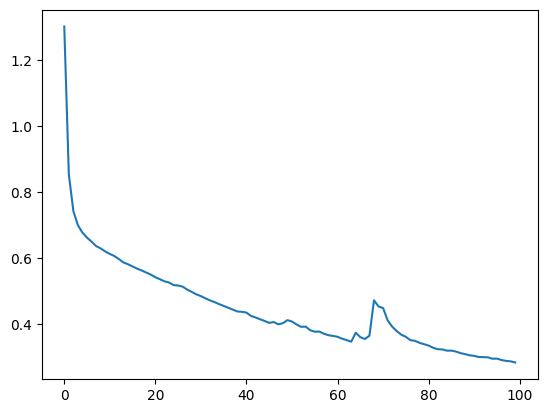

In [14]:
# plot losses
plt.plot(clf.history['loss'])

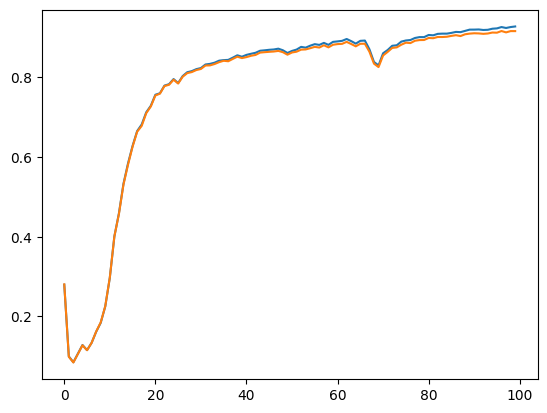

In [15]:
# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

### Predictions


In [16]:
# To get final results you may need to use a mapping for classes 
# as you are allowed to use targets like ["yes", "no", "maybe", "I don't know"]

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

BEST VALID SCORE FOR forest-cover-type : 0.9158432136933076
FINAL TEST SCORE FOR forest-cover-type : 0.9168782217326575


In [17]:
# or you can simply use the predict method

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

FINAL TEST SCORE FOR forest-cover-type : 0.9168782217326575


# Save and load Model

In [18]:
# # save state dict
# saved_filename = clf.save_model('test_model')

In [19]:
# # define new model and load save parameters
# loaded_clf = TabNetClassifier()
# loaded_clf.load_model(saved_filename)

In [20]:
# loaded_preds = loaded_clf.predict_proba(X_test)
# loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

# loaded_test_acc = accuracy_score(y_pred=loaded_y_pred, y_true=y_test)

# print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_acc}")

In [21]:
# assert(test_acc == loaded_test_acc)

# Global explainability : feat importance summing to 1

In [22]:
clf.feature_importances_
print("clf.feature_importances_:", clf.feature_importances_)
print("clf.feature_importances_.size:", clf.feature_importances_.size)

clf.feature_importances_: [8.45160426e-02 3.47159114e-02 2.35832024e-03 2.70815272e-02
 2.75353537e-03 8.72944194e-02 3.53814464e-03 2.08957417e-02
 1.01742526e-02 5.73750997e-02 1.27778798e-02 4.01940647e-02
 2.95750907e-02 4.38762543e-02 6.57560966e-03 1.55745083e-03
 2.91861197e-05 2.23626080e-03 7.04971529e-03 6.42374268e-03
 2.26491455e-02 5.27562986e-03 1.48781870e-04 2.06986913e-02
 3.13185142e-03 3.39597924e-02 4.69310785e-03 3.19808470e-08
 7.44864062e-03 4.84104598e-03 3.30855722e-03 7.58491673e-03
 6.03856242e-03 3.68628933e-03 1.88433365e-02 2.48074778e-02
 9.87137164e-06 3.26457565e-02 2.18076728e-02 1.49883275e-02
 7.86338810e-03 6.22410374e-03 2.06727170e-02 2.47925486e-02
 4.07501718e-02 1.05357711e-02 4.41630824e-02 1.17958859e-02
 1.80186251e-02 1.52294565e-02 7.84869410e-03 2.56908142e-02
 3.83336178e-02 1.05153870e-02]
clf.feature_importances_.size: 54


# Local explainability and masks

In [23]:
explain_matrix, masks = clf.explain(X_test)

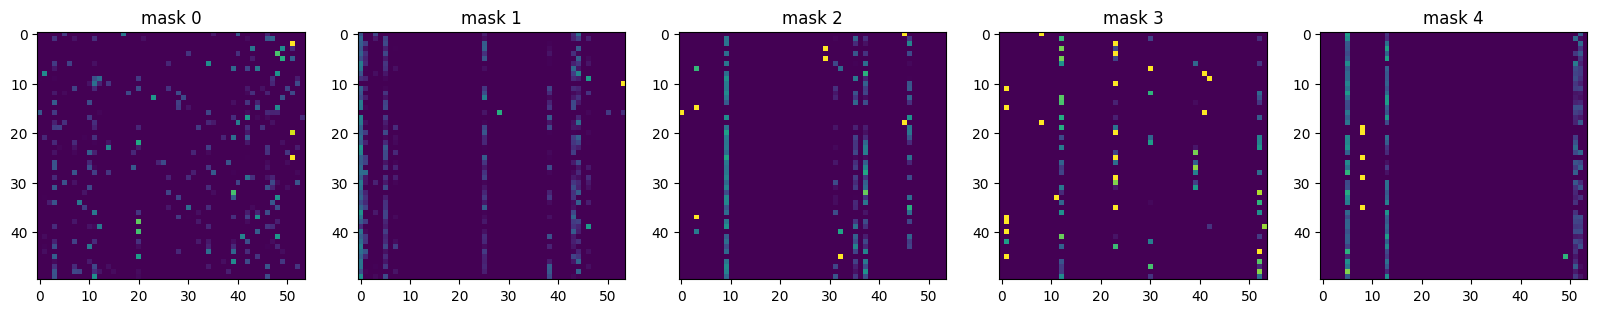

In [24]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

# Output Kaggle Data

In [25]:
X_kaggle = train_kaggle.to_numpy()
y_kaggle = clf.predict(X_kaggle).astype(str)

y_kaggle_new = np.insert(y_kaggle, 0, target)

# 将ndarray转换为DataFrame
df = pd.DataFrame(y_kaggle_new)

# 沿列轴拼接两个 DataFrame（axis=1）
combined_df = pd.concat([id_kaggle, df], axis=1)

# 将DataFrame保存为Excel文件
combined_df.to_csv("output_kaggle.csv", index=False)
print("end")

end


# XGB

In [46]:
n_estimators = 1000 if not os.getenv("CI", False) else 20

In [52]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=n_estimators,
    verbosity=0,
    silent=None,
    objective="multi:softmax",
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=40,
            verbose=10)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6], got [1 2 3 4 5 6 7]

In [1]:
preds_valid = np.array(clf_xgb.predict_proba(X_valid, ))
valid_acc = accuracy_score(y_pred=np.argmax(preds_valid, axis=1) + 1, y_true=y_valid)
print(valid_acc)

preds_test = np.array(clf_xgb.predict_proba(X_test))
test_acc = accuracy_score(y_pred=np.argmax(preds_test, axis=1) + 1, y_true=y_test)
print(test_acc)

NameError: name 'np' is not defined